In [1]:
class MTZ_TSP:
    def __init__(self, nodes, cij, xij_tag="x_%s,%s", ui_tag="u_%s", display=True):
        """Instantiate and solve the Traveling Salesperson Problem (TSP)
        based the formulation from Miller, Tucker, and Zemlin (1960).

        Parameters
        ----------
        nodes : geopandas.GeoSeries
            All nodes to be visited in the tour.
        cij : numpy.array
            All-to-all distance matrix for nodes.
        xij_tag : str
            Tour decision variable names within the model. Default is
            'x_%s,%s' where %s indicates string formatting.
        ui_tag : str
            Arbitrary real number decision variable names within the model.
            Default is 'u_%s' where %s indicates string formatting.
        display : bool
            Print out solution results.

        Attributes
        ----------
        nodes : geopandas.GeoSeries
            See description in above.
        p : int
            The number of nodes in the set.
        rp_0n : range
            Range of node IDs in ``nodes`` from 0,...,``p``.
        rp_1n : range
            Range of node IDs in ``nodes`` from 1,...,``p``.
        id : str
            Column name for ``nodes``.
        cij : numpy.array
            See description in above.
        xij_tag : str
            See description in above.
        ui_tag : str
            See description in above.
        tsp : pulp.LpProblem
            Integer Linear Programming problem instance.
        xij : numpy.array
            Binary tour decision variables (``pulp.LpVariable``).
        ui : numpy.array
            Continuous arbitrary real number decision variables
            (``pulp.LpVariable``).
        cycle_ods : dict
            Cycle origin-destination lookup keyed by origin with
            destination as the value.
        tour_pairs : list
            OD pairs comprising each abstract tour arc.
        """

        # all nodes to be visited and the distance matrix
        self.nodes, self.cij = nodes, cij
        # number of nodes in the set
        self.p = self.nodes.shape[0]
        # full and truncated range of nodes (p) in the set
        self.rp_0n, self.rp_1n = range(self.p), range(1, self.p)
        # column name for node IDs
        self.id = self.nodes.name
        # alpha tag for decision and dummy variable prefixes
        self.xij_tag, self.ui_tag = xij_tag, ui_tag

        # instantiate a model
        self.tsp = pulp.LpProblem("MTZ_TSP", pulp.LpMinimize)
        # create and set the tour decision variables
        self.tour_dvs()
        # create and set the arbitraty real number decision variables
        self.arn_dvs()
        # set the objective function
        self.objective_func()
        # node entry constraints
        self.entry_exit_constrs(entry=True)
        # node exit constraints
        self.entry_exit_constrs(entry=False)
        # subtour prevention constraints
        self.prevent_subtours()
        # solve
        self.tsp.solve()
        # origin-destination lookup
        self.get_decisions(display=display)
        # extract the sequence of nodes to construct the optimal tour
        self.construct_tour()

    def tour_dvs(self):
        """Create the tour decision variables - eq (5)."""

        def _name(_x):
            """Helper for naming variables"""
            return self.nodes[_x].split("_")[-1]

        xij = numpy.array(
            [
                [
                    pulp.LpVariable(self.xij_tag % (_name(i), _name(j)), cat="Binary")
                    for j in self.rp_0n
                ]
                for i in self.rp_0n
            ]
        )

        self.xij = xij

    def arn_dvs(self):
        """Create arbitrary real number decision variables - eq (6)."""
        ui = numpy.array(
            [pulp.LpVariable(self.ui_tag % (i), lowBound=0) for i in self.rp_0n]
        )

        self.ui = ui

    def objective_func(self):
        """Add the objective function - eq (1)."""
        self.tsp += pulp.lpSum(
            [
                self.cij[i, j] * self.xij[i, j]
                for i in self.rp_0n
                for j in self.rp_0n
                if i != j
            ]
        )

    def entry_exit_constrs(self, entry=True):
        """Add entry and exit constraints - eq (2) and (3)."""
        if entry:
            for i in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for j in self.rp_0n if i != j]) == 1
                )
        # exit constraints
        else:
            for j in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for i in self.rp_0n if i != j]) == 1
                )

    def prevent_subtours(self):
        """Add subtour prevention constraints - eq (4)."""
        for i in self.rp_1n:
            for j in self.rp_1n:
                if i != j:
                    self.tsp += (
                        self.ui[i] - self.ui[j] + self.p * self.xij[i, j] <= self.p - 1
                    )

    def get_decisions(self, display=True):
        """Fetch the selected decision variables."""
        cycle_ods = {}
        for var in self.tsp.variables():
            if var.name.startswith(self.ui_tag[0]):
                continue
            if var.varValue > 0:
                if display:
                    print("%s: %s" % (var.name, var.varValue))
                od = var.name.split("_")[-1]
                o, d = [int(tf) for tf in od.split(",")]
                cycle_ods[o] = d
        if display:
            print("Status: %s" % pulp.LpStatus[self.tsp.status])

        self.cycle_ods = cycle_ods

    def construct_tour(self):
        """Construct the tour."""
        tour_pairs = []
        for origin in self.rp_0n:
            tour_pairs.append([])
            try:
                tour_pairs[origin].append(next_origin)
                next_origin = self.cycle_ods[next_origin]
                tour_pairs[origin].append(next_origin)
            except NameError:
                next_origin = self.cycle_ods[origin]
                tour_pairs[origin].append(origin)
                tour_pairs[origin].append(next_origin)

        tour_pairs = {idx: sorted(tp) for idx, tp in enumerate(tour_pairs)}
        self.tour_pairs = tour_pairs

    def extract_tour(self, paths, id_col, leg_label="leg"):
        """Extract the tour (the legs in the journey) as a
        ``geopandas.GeoDataFrame`` of ``shapely.geometry.LineString`` objects.

        Parameters
        ----------
        paths : geopandas.GeoDataFrame
            Shortest-path routes between all observations.
        id_col : str
            ID column name.
        leg_label : str
            Column name for the tour sequence. Default is 'leg'.

        Returns
        -------
        tour : geopandas.GeoDataFrame
            Optimal tour of ``self.nodes`` sequenced by ``leg_label`` that
            retains the original index of ``paths``.
        """

        paths[leg_label] = int
        # set label of journey leg for each OD pair.
        for leg, tp in self.tour_pairs.items():
            paths.loc[paths[id_col] == tuple(tp), leg_label] = leg

        # extract only paths in the tour
        tour = paths[paths[leg_label] != int].copy()
        tour.sort_values(by=[leg_label], inplace=True)

        return tour

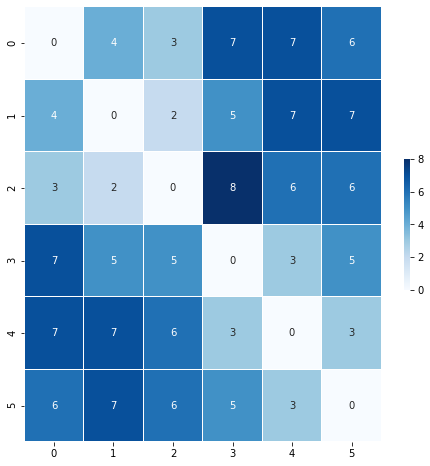

In [14]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

cities = [1,2,3,4,5,6]
dist = {
    (1,1): 0,  (1,2): 4, (1,3): 3,  (1,4): 7, (1,5): 7, (1,6): 6,
    (2,1): 4,  (2,2): 0, (2,3): 2,  (2,4): 5, (2,5): 7, (2,6): 7,
    (3,1): 3,  (3,2): 2, (3,3): 0,  (3,4): 8, (3,5): 6, (3,6): 6,
    (4,1): 7,  (4,2): 5, (4,3): 5,  (4,4): 0, (4,5): 3, (4,6): 5,
    (5,1): 7,  (5,2): 7, (5,3): 6,  (5,4): 3, (5,5): 0, (5,6): 3, 
    (6,1): 6,  (6,2): 7, (6,3): 6,  (6,4): 5, (6,5): 3, (6,6): 0,
}

R0 = [(1,6)]
R1 = [(1,2)]

city = np.array([['x1'],['x2'],['x3'],['x4'],['x5'],['x6']])
distances = np.array([x for x in dist.values()])
distances = distances.reshape([6,6])

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.show()

In [15]:
answer = mtz_tsp = MTZ_TSP(city, distances)

AttributeError: 'numpy.ndarray' object has no attribute 'name'